In [29]:
import numpy as np
import pickle
import sys
import os
import dsc
from dsc.query_engine import Query_Processor as dscQP
from dsc import dsc_io
import pickle

from pymir import pd_utils

import matplotlib.pyplot as plt
from pymir import mpl_stylesheet
from pymir import mpl_utils

from gradvi.tests import toy_priors
from gradvi.inference import Trendfiltering
from gradvi.models import basis_matrix as gvbm

import sys
sys.path.append('../dsc/functions/')

In [30]:
def stratify_dfcol(df, colname, value):
    return pd_utils.select_dfrows(df, [f"$({colname}) == {value}"])

def stratify_dfcols(df, condition_list):
    for (colname, value) in condition_list:
        df = stratify_dfcol(df, colname, value)
    return df

In [31]:
dsc_output = "/home/saikatbanerjee/scratch/work/gradvi-experiments/trendfiltering_trial"

In [32]:
db = os.path.join(dsc_output, os.path.basename(os.path.normpath(dsc_output)) + ".db")
print(db)

/home/saikatbanerjee/scratch/work/gradvi-experiments/trendfiltering_trial/trendfiltering_trial.db


In [33]:
'''
Target can be any module name, group name
or module.variable
There are two groups of methods, one of them 
needs to be force removed during query (groups = ["fit_cpt:"])
'''

target = ["simulate", "simulate.sfix", "simulate.dtrue", "simulate.n", "fit", "tfmse.err"]
#condition = ["simulate.sfix == 2", "simulate.signal == 'normal'", "simulate.dims == '(50, 200)'"]
#groups = ["fit_cpt:"]
condition = [""]
qp = dscQP(db, target, condition)
qp_df = qp.output_table

qp_df

,DSC,simulate,simulate.sfix,simulate.output.file,simulate.n,simulate.dtrue,fit,fit.output.file,tfmse.err:output
0,1,changepoint,4,changepoint/changepoint_1,1024,1,gradvi_compound_init,gradvi_compound_init/changepoint_1_genlasso_1_...,tfmse/changepoint_1_genlasso_1_gradvi_compound...
1,1,changepoint,4,changepoint/changepoint_1,1024,1,gradvi_compound_scaled,gradvi_compound_scaled/changepoint_1_gradvi_co...,tfmse/changepoint_1_gradvi_compound_scaled_1_t...
2,1,changepoint,4,changepoint/changepoint_1,1024,1,gradvi_compound_scaled_init,gradvi_compound_scaled_init/changepoint_1_genl...,tfmse/changepoint_1_genlasso_1_gradvi_compound...
3,1,changepoint,4,changepoint/changepoint_1,1024,1,mr_ash,mr_ash/changepoint_1_mr_ash_1,tfmse/changepoint_1_mr_ash_1_tfmse_1
4,1,changepoint,4,changepoint/changepoint_1,1024,1,mr_ash_init,mr_ash_init/changepoint_1_genlasso_1_mr_ash_in...,tfmse/changepoint_1_genlasso_1_mr_ash_init_1_t...
5,1,changepoint,4,changepoint/changepoint_1,1024,1,mr_ash_scaled,mr_ash_scaled/changepoint_1_mr_ash_scaled_1,tfmse/changepoint_1_mr_ash_scaled_1_tfmse_1
6,1,changepoint,4,changepoint/changepoint_1,1024,1,mr_ash_scaled_init,mr_ash_scaled_init/changepoint_1_genlasso_1_mr...,tfmse/changepoint_1_genlasso_1_mr_ash_scaled_i...
7,1,changepoint,4,changepoint/changepoint_1,1024,1,gradvi_direct,gradvi_direct/changepoint_1_gradvi_direct_1,tfmse/changepoint_1_gradvi_direct_1_tfmse_1
8,1,changepoint,4,changepoint/changepoint_1,1024,1,gradvi_direct_init,gradvi_direct_init/changepoint_1_genlasso_1_gr...,tfmse/changepoint_1_genlasso_1_gradvi_direct_i...
9,1,changepoint,4,changepoint/changepoint_1,1024,1,gradvi_compound,gradvi_compound/changepoint_1_gradvi_compound_1,tfmse/changepoint_1_gradvi_compound_1_tfmse_1


In [34]:
data = dsc_io.load_dsc(os.path.join(dsc_output, f"{qp_df['simulate.output.file'].iloc[0]}.pkl"))

In [35]:
methods = qp_df["fit"].unique()
res = dict()
tfmse = dict()
for method in methods:
    dfs = stratify_dfcols(qp_df, [('fit', method)])
    f_ext = "pkl" if method.startswith("gradvi") else "rds"
    resfile = os.path.join(dsc_output, f"{dfs['fit.output.file'].iloc[0]}.{f_ext}")
    res[method] = dsc_io.load_dsc(resfile)
    errfile = os.path.join(dsc_output, f"{dfs['tfmse.err:output'].iloc[0]}.rds")
    tfmse[method] = dsc_io.load_dsc(errfile)['err']

In [36]:
tfmse

{'gradvi_compound_init': 0.00020237819147842447,
 'gradvi_compound_scaled': 0.0013492526879456583,
 'gradvi_compound_scaled_init': 0.00020237819147842447,
 'mr_ash': 0.09263761363373267,
 'mr_ash_init': 0.0001368941232197376,
 'mr_ash_scaled': 0.038050503676160245,
 'mr_ash_scaled_init': 0.0008583120910487525,
 'gradvi_direct': 0.00031373058171762114,
 'gradvi_direct_init': 0.00021661192143446396,
 'gradvi_compound': 0.0013492526879456583}

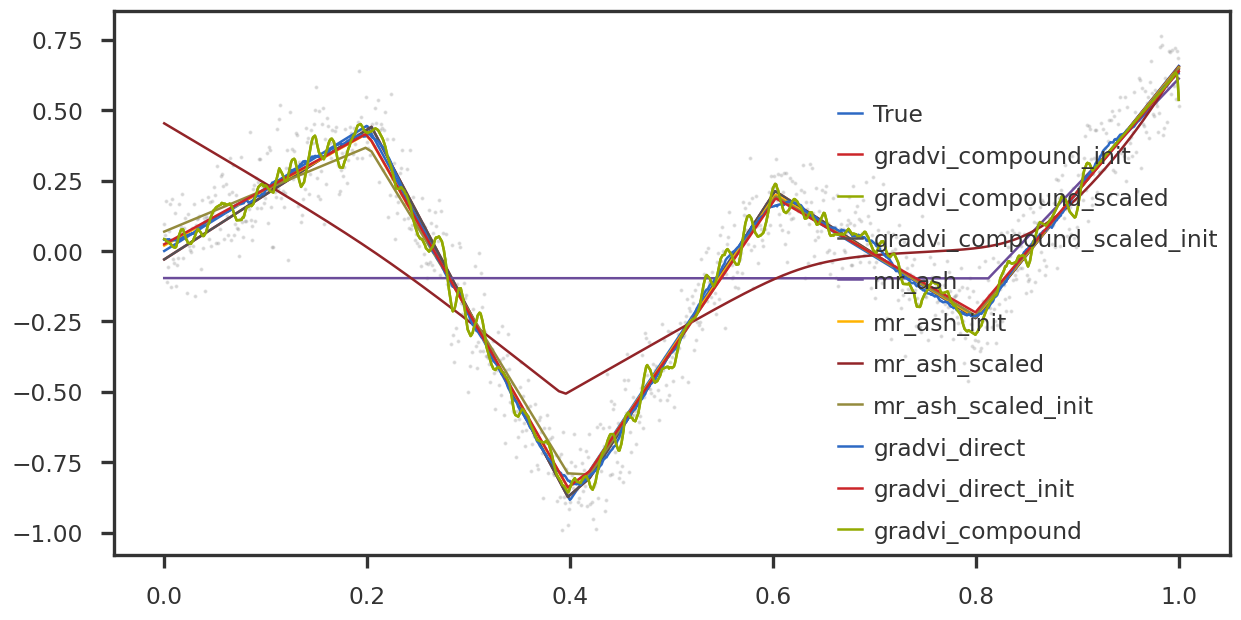

In [38]:
mpl_stylesheet.banskt_presentation(splinecolor = 'black', dpi = 120)

fig = plt.figure(figsize = (12, 6))
ax1 = fig.add_subplot(111)

y = data['y']
ytrue = data['ytrue']
x = np.linspace(0, 1, y.shape[0])

ax1.scatter(x, y, s = 2, color = 'grey', alpha = 0.2)
ax1.plot(x, ytrue, label = 'True')

for method in methods:
    ym = res[method]['ypred']
    ax1.plot(x, ym, label = method)

ax1.legend()
plt.show()